# 02. Data Preprocessing - GreenSpace CNN

This notebook handles data preprocessing for the multi-task greenspace CNN:
- Survey response cleaning and label processing  
- Image preprocessing and augmentation setup
- Train/validation/test splits
- Data pipeline creation for TensorFlow/Keras

## Steps (tentative)
1. Load and clean survey data
2. Handle multi-rater aggregation 
3. Process images (resize, normalize)
4. Create data splits
5. Set up TensorFlow data pipelines

How to transform the data we have:


In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
import random
import tensorflow as tf

# Global reproducibility controls
GLOBAL_SEED = 123
RNG_STATE_SPLIT = 123
RNG_STATE_SPLIT_2 = 456
RNG_STATE_AUG = 123

# Set seeds for libraries
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)
import matplotlib.pyplot as plt
import tensorflow as tf

### Step 1: validate CSV ↔ images

In [ ]:
csv = Path('../data/raw/survey_responses_clean.csv')
imgs = Path('../data/raw/images')
assert csv.exists() and imgs.exists(), 'Missing CSV or images folder'

df = pd.read_csv(csv)
assert 'image_filename' in df.columns, "CSV needs 'image_filename'"
exp = set(df['image_filename'].dropna().astype(str).unique())
present = {p.name for p in imgs.iterdir() if p.is_file()}
missing = sorted(exp - present)
extra = sorted(present - exp)

print(f'expected={len(exp)} present={len(present)} missing={len(missing)} extra={len(extra)}')
if missing: print('missing (first 10):', *missing[:10], sep='\n')
if extra: print('extra (first 10):', *extra[:10], sep='\n')

if missing or extra:
    raise SystemExit('Fix naming/alignment before proceeding.')
print('Alignment OK')


expected=49 present=49 missing=0 extra=0
Alignment OK


### Step 2: aggregate rater labels → soft & hard per image

In [7]:

csv = Path('../data/raw/survey_responses_clean.csv')
out = Path('../data/processed'); out.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(csv)
key = 'image_filename'

# Raw column names (as in the CSV)
bin_cols_raw = ['Sports Field','Multipurpose Open Area',"Children's playground",'Water feature','Gardens','Walking paths','Built structures']
shade_col_raw = 'Shade along paths'
score_col_raw = 'Structured–Unstructured Rating'

# Map to numeric with floats to allow NaN
yn = {'Yes':1, 'No':0, 'yes':1, 'no':0}
for c in bin_cols_raw:
    df[c] = df[c].map(yn).astype(float)

shade_map = {'None':0,'Some':1,'Abundant':2}
df['shade_i'] = df[shade_col_raw].map(shade_map).astype(float)

# Extract leading 1–5 from strings like "5 - Very Unstructured"
df['score_i'] = pd.to_numeric(df[score_col_raw].astype(str).str.extract(r'^(\d)')[0], errors='coerce')

# Group by image
g = df.groupby(key, dropna=False)

# n_ratings
n = g.size().rename('n_ratings')

# Binary soft probs (mean over available ratings)
bin_soft = g[bin_cols_raw].mean().rename(columns={
    'Sports Field':'sports_field_p',
    'Multipurpose Open Area':'multipurpose_open_area_p',
    "Children's playground":'childrens_playground_p',
    'Water feature':'water_feature_p',
    'Gardens':'gardens_p',
    'Walking paths':'walking_paths_p',
    'Built structures':'built_structures_p',
}).astype(float)

# Shade soft probs
shade_probs = g['shade_i'].apply(lambda s: s.value_counts(normalize=True)).unstack(fill_value=0.0)
shade_probs = shade_probs.reindex(columns=[0.0,1.0,2.0], fill_value=0.0).astype(float)
shade_probs.columns = ['shade_p_none','shade_p_some','shade_p_abundant']

# Score soft probs + mean
score_probs = g['score_i'].apply(lambda s: s.value_counts(normalize=True)).unstack(fill_value=0.0)
score_probs = score_probs.reindex(columns=[1.0,2.0,3.0,4.0,5.0], fill_value=0.0).astype(float)
score_probs.columns = [f'score_p_{i}' for i in [1,2,3,4,5]]
score_mean = g['score_i'].mean().rename('score_mean').astype(float)

# Assemble soft labels
soft = pd.concat([n, bin_soft, shade_probs, score_probs, score_mean], axis=1).reset_index()
soft.to_csv(out / 'labels_soft.csv', index=False)

# Build hard labels from soft (fill NaNs with 0 before argmax/threshold)
hard = soft[[key,'n_ratings']].copy()
for col in ['sports_field','multipurpose_open_area','childrens_playground','water_feature','gardens','walking_paths','built_structures']:
    hard[col] = soft[f'{col}_p'].fillna(0.0).ge(0.5).astype(int)

shade_cols = ['shade_p_none','shade_p_some','shade_p_abundant']
shade_arr = soft[shade_cols].fillna(0.0).to_numpy(dtype=float)
hard['shade_class'] = shade_arr.argmax(axis=1)  # 0/1/2

score_cols = [f'score_p_{i}' for i in [1,2,3,4,5]]
score_arr = soft[score_cols].fillna(0.0).to_numpy(dtype=float)
hard['score_class'] = score_arr.argmax(axis=1) + 1  # 1..5

hard.to_csv(out / 'labels_hard.csv', index=False)

print('Wrote:', out/'labels_soft.csv')
print('Wrote:', out/'labels_hard.csv')


Wrote: ../data/processed/labels_soft.csv
Wrote: ../data/processed/labels_hard.csv


### Step 3: label prevalence (from soft labels)

In [8]:


soft_path = Path('../data/processed/labels_soft.csv')
assert soft_path.exists(), f'Missing {soft_path}. Run Step 2 first.'

df = pd.read_csv(soft_path)

# Binary prevalence (mean probability = expected positive rate)
binary_cols = [c for c in df.columns if c.endswith('_p') and not c.startswith(('shade_p_', 'score_p_'))]
bin_prev = df[binary_cols].mean().sort_values()
print('Binary prevalence (expected positive rate):')
print(bin_prev.to_frame('prevalence').round(3))

# Shade (3-class) distribution (dataset-level)
shade_cols = ['shade_p_none','shade_p_some','shade_p_abundant']
shade_prev = df[shade_cols].mean()
print('\nShade distribution:')
print(shade_prev.rename(lambda c: c.replace('shade_p_','')).to_frame('prob').round(3))

# Structured–Unstructured (1–5) distribution
score_cols = [f'score_p_{i}' for i in [1,2,3,4,5]]
score_prev = df[score_cols].mean()
print('\nStructured–Unstructured (1–5) distribution:')
print(score_prev.rename(lambda c: c.replace('score_p_','score_')).to_frame('prob').round(3))

# Rating count sanity check
if 'n_ratings' in df.columns:
    print('\nNumber of ratings per image (summary):')
    print(df['n_ratings'].describe().to_string())


Binary prevalence (expected positive rate):
                          prevalence
gardens_p                      0.088
childrens_playground_p         0.112
water_feature_p                0.192
sports_field_p                 0.218
built_structures_p             0.327
multipurpose_open_area_p       0.456
walking_paths_p                0.567

Shade distribution:
           prob
none      0.000
some      0.925
abundant  0.075

Structured–Unstructured (1–5) distribution:
          prob
score_1  0.133
score_2  0.168
score_3  0.128
score_4  0.236
score_5  0.335

Number of ratings per image (summary):
count    49.000000
mean      2.448980
std       1.415115
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       8.000000


## Augmentation Ideas

- Geometric: horizontal/vertical flips, 90° rotations, random crop→resize (90–100% area), small translate (±5%).
- Photometric: brightness/contrast ±10% (keep mild since “shade” is label-like). Avoid heavy color/hue.

### Step 4: oversample (rare vs other) + rotation/brightness augmentation

In [ ]:


hard_p = Path('../data/processed/labels_hard.csv')
soft_p = Path('../data/processed/labels_soft.csv')
img_dir = Path('../data/raw/images')

dh = pd.read_csv(hard_p)
ds = pd.read_csv(soft_p)
# Join to keep flexibility later (we only need hard to detect rarity)
df = dh.merge(ds, on=['image_filename','n_ratings'], how='inner')

df['image_path'] = df['image_filename'].apply(lambda x: str(img_dir / x))

# Dynamically choose rare labels from soft prevalence
soft_probs = [c for c in ds.columns if c.endswith('_p') and not c.startswith(('shade_p_', 'score_p_'))]
soft_prev = ds[soft_probs].mean()
rare_threshold = 0.25
# Strip only a trailing '_p' (avoid removing the '_p' inside names like 'childrens_playground_p')
strip_p = lambda s: s[:-2] if s.endswith('_p') else s
rare_labels = [strip_p(c) for c, v in soft_prev.items() if v <= rare_threshold]
if not rare_labels:
    rare_labels = [strip_p(c) for c in soft_prev.sort_values().head(2).index]

# Mark images positive for any rare label
df['is_rare_pos'] = df[[*rare_labels]].any(axis=1)

rare_paths = df.loc[df['is_rare_pos'], 'image_path'].tolist()
other_paths = df.loc[~df['is_rare_pos'], 'image_path'].tolist()
print(f'rare_labels={rare_labels}')
print(f'rare={len(rare_paths)} other={len(other_paths)}')

# Dynamic weights with safe fallbacks
target_rare = 0.5
if len(rare_paths) == 0 and len(other_paths) == 0:
    weights = [0.5, 0.5]
elif len(rare_paths) == 0:
    weights = [0.0, 1.0]
elif len(other_paths) == 0:
    weights = [1.0, 0.0]
else:
    weights = [target_rare, 1.0 - target_rare]

IMG_SIZE = (512, 512)

def decode(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Mild, label-preserving augmentation: rotate 0/90/180/270 and brightness ±10%
def augment(img):
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    delta = tf.random.uniform((), minval=-0.1, maxval=0.1)
    img = tf.clip_by_value(img + delta, 0.0, 1.0)
    return img
    # try to save the augmented images. 

def make_ds(paths, augment_flag=True, shuffle_seed=123):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if len(paths) > 1:
        ds = ds.shuffle(len(paths), seed=shuffle_seed, reshuffle_each_iteration=True)
    ds = ds.map(decode, num_parallel_calls=tf.data.AUTOTUNE)
    if augment_flag:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    return ds

rare_ds = make_ds(rare_paths, augment_flag=True, shuffle_seed=RNG_STATE_AUG)
other_ds = make_ds(other_paths, augment_flag=True, shuffle_seed=RNG_STATE_SPLIT_2)

# Oversampled mix with dynamic weights
mixed = tf.data.Dataset.sample_from_datasets([rare_ds, other_ds], weights=weights, seed=GLOBAL_SEED)
train_preview = mixed.batch(8).prefetch(tf.data.AUTOTUNE)

print(f'Oversampled + augmented stream ready (weights={weights}).')


rare_labels=['sports_field', 'childrens_playground', 'water_feature', 'gardens']
rare=26 other=23
Oversampled + augmented stream ready (weights=[0.5, 0.5]).


#### Step 4A
Export output artifacts for review

In [13]:
# Export quick diagnostics to data/interim
import json

soft_path = Path('../data/processed/labels_soft.csv')
hard_path = Path('../data/processed/labels_hard.csv')
interim = Path('../data/interim'); interim.mkdir(parents=True, exist_ok=True)

soft_df = pd.read_csv(soft_path)
hard_df = pd.read_csv(hard_path)

# Prevalence (binary, shade, score) → CSV
binary_cols = [c for c in soft_df.columns if c.endswith('_p') and not c.startswith(('shade_p_', 'score_p_'))]
shade_cols  = [c for c in soft_df.columns if c.startswith('shade_p_')]
score_cols  = [c for c in soft_df.columns if c.startswith('score_p_')]

prev_df = pd.DataFrame({
    'metric': ['binary_'+c for c in binary_cols] + ['shade_'+c for c in shade_cols] + ['score_'+c for c in score_cols],
    'prevalence': list(soft_df[binary_cols].mean().values) + list(soft_df[shade_cols].mean().values) + list(soft_df[score_cols].mean().values)
})
prev_df.to_csv(interim / 'prevalence_summary.csv', index=False)

# Rare labels used for oversampling (threshold=0.25) → JSON
strip_p = lambda s: s[:-2] if s.endswith('_p') else s
soft_prev_bin = soft_df[binary_cols].mean()
rare_labels = [strip_p(c) for c, v in soft_prev_bin.items() if v <= 0.25]
if not rare_labels:
    rare_labels = [strip_p(c) for c in soft_prev_bin.sort_values().head(2).index]

with open(interim / 'rare_labels.json', 'w') as f:
    json.dump({'rare_labels': rare_labels, 'threshold': 0.25}, f, indent=2)

print('Wrote:', interim/'prevalence_summary.csv', 'and', interim/'rare_labels.json')

Wrote: ../data/interim/prevalence_summary.csv and ../data/interim/rare_labels.json


2025-09-14 14:09:20.259320: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-09-14 14:09:20.259456: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-14 14:09:20.259469: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-14 14:09:20.259694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-14 14:09:20.259718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


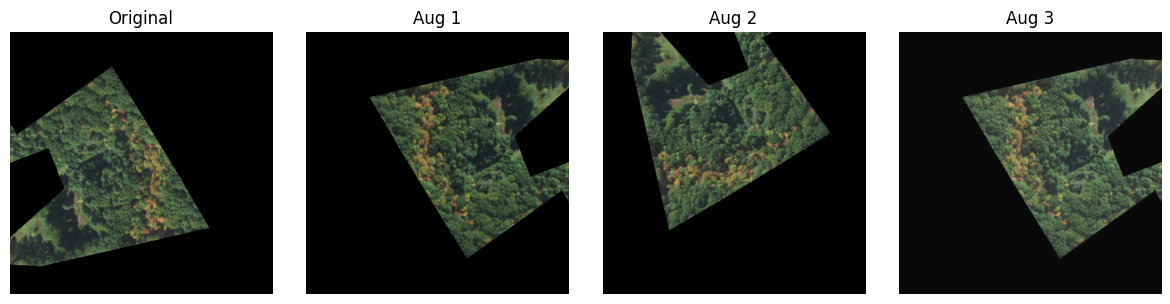

Saved: ../data/interim/aug_preview/USA_97291-0090_1_1-00000_f01_p000_aug_preview.png


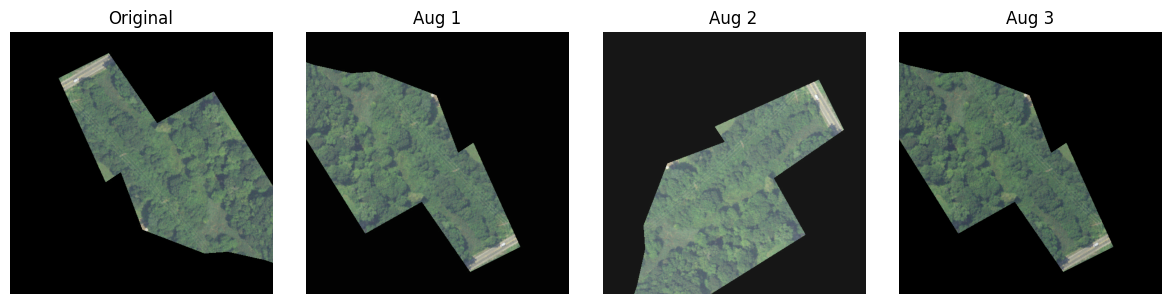

Saved: ../data/interim/aug_preview/USA_72505-0610_1_0-00000_f00_p000_aug_preview.png


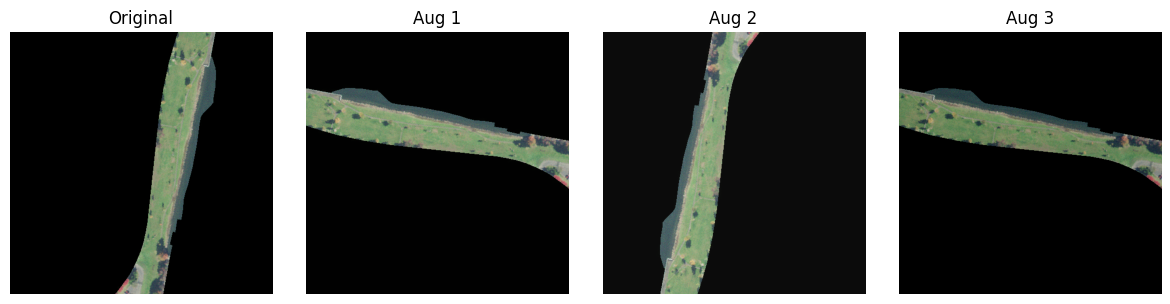

Saved: ../data/interim/aug_preview/USA_0952000-0033_1_1-00000_f01_p000_aug_preview.png


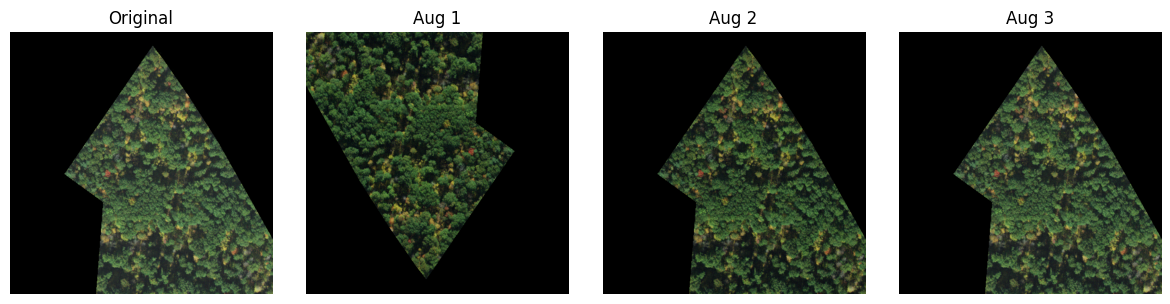

Saved: ../data/interim/aug_preview/USA_97291-0204_1_1-00000_f01_p000_aug_preview.png


In [4]:
# Save a few augmented previews to data/interim/aug_preview

def decode_np(path):
    img = tf.io.read_file(path); img = tf.io.decode_jpeg(img, channels=3)
    return (tf.cast(img, tf.float32) / 255.0).numpy()

def augment_np(img_np):
    img = tf.convert_to_tensor(img_np, dtype=tf.float32)
    k = tf.random.uniform((), 0, 4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    delta = tf.random.uniform((), -0.1, 0.1)
    img = tf.clip_by_value(img + delta, 0.0, 1.0)
    return img.numpy()

img_dir = Path('../data/raw/images')
preview_dir = Path('../data/interim/aug_preview'); preview_dir.mkdir(parents=True, exist_ok=True)

# Prefer a couple rare/other paths if present; else fallback to first few images
try:
    candidates = (rare_paths[:2] if 'rare_paths' in locals() else []) + (other_paths[:2] if 'other_paths' in locals() else [])
except:
    candidates = []
if not candidates:
    candidates = [str(p) for p in img_dir.glob('*.jpg')][:4]

for path in candidates:
    orig = decode_np(path)
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes[0].imshow(orig); axes[0].set_title('Original'); axes[0].axis('off')
    for i in range(1, 4):
        axes[i].imshow(augment_np(orig)); axes[i].set_title(f'Aug {i}'); axes[i].axis('off')
    plt.tight_layout()
    out_path = preview_dir / (Path(path).stem + '_aug_preview.png')
    plt.savefig(out_path, dpi=120, bbox_inches='tight'); plt.show()
    print('Saved:', out_path)

### Step 5: dynamic 60/20/20 split → train/val/test manifests

In [ ]:

from sklearn.model_selection import train_test_split

soft_csv = Path('../data/processed/labels_soft.csv')
hard_csv = Path('../data/processed/labels_hard.csv')
img_dir = Path('../data/raw/images')
out_dir = Path('../data/processed/splits'); out_dir.mkdir(parents=True, exist_ok=True)

soft = pd.read_csv(soft_csv)
hard = pd.read_csv(hard_csv)

# Merge soft and hard; keep one row per image
df = hard.merge(soft, on=['image_filename','n_ratings'], how='inner')

# Build absolute image_path for convenience
df['image_path'] = df['image_filename'].apply(lambda x: str((img_dir / x).resolve()))

# Identify columns
soft_prob_cols = [c for c in df.columns if c.endswith('_p')]
soft_prob_cols = [c for c in soft_prob_cols if not c.startswith(('shade_p_','score_p_'))] + \
                  [c for c in df.columns if c.startswith('shade_p_')] + \
                  [c for c in df.columns if c.startswith('score_p_')]

hard_bin_cols = [c for c in ['sports_field','multipurpose_open_area','childrens_playground','water_feature','gardens','walking_paths','built_structures'] if c in df.columns]
other_hard_cols = [c for c in ['shade_class','score_class'] if c in df.columns]
keep_cols = ['image_path','image_filename','n_ratings'] + soft_prob_cols + hard_bin_cols + other_hard_cols

# Define rare labels dynamically from soft prevalence (for stratification hints)
soft_prev = df[[c for c in df.columns if c.endswith('_p') and not c.startswith(('shade_p_','score_p_'))]].mean()
strip_p = lambda s: s[:-2] if s.endswith('_p') else s
rare_labels = [strip_p(c) for c, v in soft_prev.items() if v <= 0.25]
if not rare_labels:
    rare_labels = [strip_p(c) for c in soft_prev.sort_values().head(2).index]

# Stratify proxy: number of rare positives (clipped) per image
stratum = df[[c for c in rare_labels if c in df.columns]].sum(axis=1)
stratum = stratum.clip(upper=2)  # 0,1,2

# Compute dynamic sizes
N = len(df)
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2
train_size = max(1, round(train_ratio * N))
val_size   = max(1, round(val_ratio * N))
# Adjust to sum to N
test_size  = max(1, N - train_size - val_size)
if train_size + val_size + test_size != N:
    # Fix rounding drift by adjusting test_size
    test_size = N - train_size - val_size

# First split: train vs temp (val+test)
train_df, temp_df = train_test_split(
    df, train_size=train_size, random_state=RNG_STATE_SPLIT, stratify=stratum if stratum.nunique()>1 else None)

# Second split: val vs test from temp
temp_stratum = temp_df[[*rare_labels]].sum(axis=1).clip(upper=2) if rare_labels else None
val_prop = val_size / max(1, len(temp_df))
val_df, test_df = train_test_split(
    temp_df, test_size=(1 - val_prop), random_state=RNG_STATE_SPLIT_2,
    stratify=temp_stratum if temp_stratum is not None and temp_stratum.nunique()>1 else None)

# Save manifests
train_df[keep_cols].to_csv(out_dir / 'train.csv', index=False)
val_df[keep_cols].to_csv(out_dir / 'val.csv', index=False)
test_df[keep_cols].to_csv(out_dir / 'test.csv', index=False)

print('Split sizes:', len(train_df), len(val_df), len(test_df))
print('Rare labels used:', rare_labels)



Split sizes: 29 10 10
Rare labels used: ['sports_field', 'childrens_playground', 'water_feature', 'gardens']
